## Web scrapping using python

#### References
1. [Practical Introduction to Web Scraping in Python](https://realpython.com/python-web-scraping-practical-introduction/)
2. [Web Scraping using Python](https://www.datacamp.com/community/tutorials/web-scraping-using-python)

In [ ]:
# $ python3 -m venv venv
# $ . ./venv/bin/activate

In [2]:
#Better
!pip install requests BeautifulSoup4 fire

     |████████████████████████████████| 81kB 2.1MB/s 
  Created wheel for fire: filename=fire-0.3.1-py2.py3-none-any.whl size=111005 sha256=2dc51769607be33c00aae7496c83eed93b4b979b0b2d50795dba836de7c3f4bc
  Stored in directory: /root/.cache/pip/wheels/c1/61/df/768b03527bf006b546dce284eb4249b185669e65afc5fbb2ac
Successfully built fire


In [4]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os, sys

import fire

In [5]:
#%%writefile ../pyscrap_url.py

def simple_get(url):
    """
    Attempts to get the content at `url` by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None.
    """
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content  #.encode(BeautifulSoup.original_encoding)
            else:
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None


def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)


def log_error(e):
    """
    It is always a good idea to log errors. 
    This function just prints them, but you can
    make it do anything.
    """
    print(e)
    
def get_elements(url, tag='',search={}, fname=None):
    """
    Downloads a page specified by the url parameter
    and returns a list of strings, one per tag element
    """
    
    if isinstance(url,str):
        response = simple_get(url)
    else:
        #if already it is a loaded html page
        response = url

    if response is not None:
        html = BeautifulSoup(response, 'html.parser')
        
        res = []
        if tag:    
            for li in html.select(tag):
                for name in li.text.split('\n'):
                    if len(name) > 0:
                        res.append(name.strip())
                       
                
        if search:
            soup = html            
            
            
            r = ''
            if 'find' in search.keys():
                print('findaing',search['find'])
                soup = soup.find(**search['find'])
                r = soup

                
            if 'find_all' in search.keys():
                print('findaing all of',search['find_all'])
                r = soup.find_all(**search['find_all'])
   
            if r:
                for x in list(r):
                    if len(x) > 0:
                        res.extend(x)
            
        return res

    # Raise an exception if we failed to get any data from the url
    raise Exception('Error retrieving contents at {}'.format(url))    
    
    
if get_ipython().__class__.__name__ == '__main__':
    fire(get_tag_elements)

In [7]:
url= 'https://www.atlanticcouncil.org/blogs/africasource/african-leaders-respond-to-coronavirus-on-twitter/#east-africa'
response = simple_get(url)

In [8]:
res = get_elements(response, search={'find_all':{'class_':'twitter-tweet'}})
top_leaders = []
for i in res:
    if i.string != None:
        top_leaders.append(i.string)

findaing all of {'class_': 'twitter-tweet'}


In [82]:
top_leaders_f={}
val= top_leaders[2][0]
j=1
for i in top_leaders:
  if i[0] ==val:
    top_leaders_f[j]=i
    j+=1


In [9]:
influencial_url = get_elements('https://africafreak.com/100-most-influential-twitter-users-in-africa', tag='h2')
inf_response = influencial_url[:100]


In [12]:
import os
import pandas as pd
import re
import string

!pip install tweepy
import tweepy
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

#sentiment analysis package
!pip install textblob
from textblob import TextBlob

#general text pre-processor
!pip install nltk
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')

#tweet pre-processor 
!pip install tweet-preprocessor
import preprocessor as p



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
consumer_key = 'TWITTER API KEY'
consumer_secret = 'TWITTER API KEY SECRET'
access_token='ACCESS_TOKEN'
access_token_secret = 'ACCESS_TOKEN_SECRET'

# This handles Twitter authetification and the connection to Twitter Streaming API
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [15]:
class tweetsearch():
    '''
    This is a basic class to search and download twitter data.
    You can build up on it to extend the functionalities for more 
    sophisticated analysis
    '''
    def __init__(self, cols=None,auth=None):
        #
        if not cols is None:
            self.cols = cols
        else:
            self.cols = ['id', 'created_at', 'source', 'original_text','clean_text', 
                    'sentiment','polarity','subjectivity', 'lang',
                    'favorite_count', 'retweet_count', 'original_author',   
                    'possibly_sensitive', 'hashtags',
                    'user_mentions', 'place', 'place_coord_boundaries']
            
        if auth is None:
            # Variables that contains the user credentials to access Twitter API 
            consumer_key = 'TWITTER API KEY'
            consumer_secret ='TWITTER API KEY SECRET'
            access_token = 'ACCESS_TOKEN'
            access_token_secret = 'ACCESS_TOKEN_SECRET'

            # This handles Twitter authetification and the connection to Twitter Streaming API
            auth = OAuthHandler(consumer_key, consumer_secret)
            auth.set_access_token(access_token, access_token_secret)
                       
        self.auth = auth
        self.api = tweepy.API(auth, wait_on_rate_limit=True) 
        self.filtered_tweet = ''
            

    def clean_tweets(self, twitter_text):

        # use pre processor
        tweet = p.clean(twitter_text)

         # HappyEmoticons
        emoticons_happy = set([
            ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
            ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
            '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
            'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
            '<3'
            ])

        # Sad Emoticons
        emoticons_sad = set([
            ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
            ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
            ':c', ':{', '>:\\', ';('
            ])

        # Emoji patterns
        emoji_pattern = re.compile("["
                 u"\U0001F600-\U0001F64F"  # emoticons
                 u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                 u"\U0001F680-\U0001F6FF"  # transport & map symbols
                 u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                 u"\U00002702-\U000027B0"
                 u"\U000024C2-\U0001F251"
                 "]+", flags=re.UNICODE)

        # combine sad and happy emoticons
        emoticons = emoticons_happy.union(emoticons_sad)

        stop_words = set(stopwords.words('english'))
        word_tokens = nltk.word_tokenize(tweet)
        # after tweepy preprocessing the colon symbol left remain after      
        # removing mentions
        tweet = re.sub(r':', '', tweet)
        tweet = re.sub(r'‚Ä¶', '', tweet)

        # replace consecutive non-ASCII characters with a space
        tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

        # remove emojis from tweet
        tweet = emoji_pattern.sub(r'', tweet)

        # filter using NLTK library append it to a string
        filtered_tweet = [w for w in word_tokens if not w in stop_words]

        # looping through conditions
        filtered_tweet = []    
        for w in word_tokens:
        # check tokens against stop words , emoticons and punctuations
            if w not in stop_words and w not in emoticons and w not in string.punctuation:
                filtered_tweet.append(w)

        return ' '.join(filtered_tweet)            

    def get_tweets(self, handles, csvfile=None):
        
        df = pd.DataFrame(columns=self.cols)
        
        if not csvfile is None:
            # If the file exists, then read the existing data from the CSV file.
            if os.path.exists(csvfile):
                df = pd.read_csv(csvfile, header=0)
            
        # page attribute in tweepy.cursor and iteration
        for handle in handles:
            # the you receive from the Twitter API is in a JSON format and has quite an amount of information attached
            for status in self.api.user_timeline(id=handle,count=100, include_rts=False): 
                new_entry = []
                status = status._json               
                # filter by language
                # if status['lang'] != 'en':
                
                #    continue

                # if this tweet is a retweet update retweet count
                if status['created_at'] in df['created_at'].values:
                    i = df.loc[df['created_at'] == status['created_at']].index[0]
                    #
                    cond1 = status['favorite_count'] != df.at[i, 'favorite_count']
                    cond2 = status['retweet_count'] != df.at[i, 'retweet_count']
                    if cond1 or cond2:
                        df.at[i, 'favorite_count'] = status['favorite_count']
                        df.at[i, 'retweet_count'] = status['retweet_count']
                    continue

                #calculate sentiment
                filtered_tweet = self.clean_tweets(status['text'])
                blob = TextBlob(filtered_tweet)
                Sentiment = blob.sentiment     
                polarity = Sentiment.polarity
                subjectivity = Sentiment.subjectivity

                new_entry += [status['id'], status['created_at'],
                              status['source'], status['text'], filtered_tweet, 
                              Sentiment, polarity, subjectivity, status['lang'],
                              status['favorite_count'], status['retweet_count']]

                new_entry.append(status['user']['screen_name'])

                try:
                    is_sensitive = status['possibly_sensitive']
                except KeyError:
                    is_sensitive = None

                new_entry.append(is_sensitive)

                hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
                new_entry.append(hashtags)  # append the hashtags

                #
                mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
                new_entry.append(mentions)  # append the user mentions

                try:
                    xyz = status['place']['bounding_box']['coordinates']
                    coordinates = [coord for loc in xyz for coord in loc]
                except TypeError:
                    coordinates = None
                #
                new_entry.append(coordinates)

                try:
                    location = status['user']['location']
                except TypeError:
                    location = ''
                #
                new_entry.append(location)

                #now append a row to the dataframe
                single_tweet_df = pd.DataFrame([new_entry], columns=self.cols)
                df = df.append(single_tweet_df, ignore_index=True)
    
        df['original_author'] = df['original_author'].str.lower()
    
        df['timestamp'] = df.created_at.map(pd.Timestamp)
        df = df.sort_values('timestamp').set_index('timestamp')
        df = df.drop('id',axis=1)
        
        if not csvfile is None:
            #save it to file
            df.to_csv(csvfile, index=True, encoding="utf-8")
            

        return df

In [17]:
def extract_twitter_handle_inf(data):
  twitter_handle = []
  for i in data:
    twitter_handle.append(i.split('(',1)[1].split(')')[0].replace('@','')) 
  good_handles =[]
  for j in twitter_handle:
      try:
          user = api.get_user(j)
          good_handles.append(j)
      except:
          twitter_handle.remove(j)
  
  return good_handles

def extract_twitter_handle(data):
    regx = re.compile(r'@[a-zA-Z0-9_]{0,15}')
    tags = ''.join(data)
    all = regx.findall(tags)
    good_handles = []
    for j in all:
        good = j.replace('@','')
        good_handles.append(good)
    better_handles=[]
    for better in good_handles:
        try:
            user = api.get_user(better)
            better_handles.append(better)
        except:
            good_handles.remove(better)
    
    return better_handles

In [18]:
top_inf = extract_twitter_handle_inf(inf_response)
top_lead = extract_twitter_handle(top_leaders)

In [54]:
ts = tweetsearch()
df_inf = ts.get_tweets(top_inf)
df_lead = ts.get_tweets(top_lead)
     


In [21]:
top_lead = extract_twitter_handle(top_leaders)
df_lead = ts.get_tweets(top_lead)


In [36]:
def get_user_data(data):
    full_name = []
    No_of_followers = []
    statusesCount = []
    verified = []
    screenName = []
    for handle in data:
        user = api.get_user(handle)
        full_name.append(user.name)
        No_of_followers.append(user.followers_count)
        statusesCount.append(user.statuses_count)
        verified.append(user.verified)
        screenName.append(handle.lower())
    df = pd.DataFrame()
    df['full name'] = full_name
    df['No of followers'] = No_of_followers
    df['statusesCount'] = statusesCount
    df['verified'] = verified
    df['twitter handle'] = screenName
    
    return df

In [55]:
top_influencers_data = get_user_data(top_inf)
top_leaders_data = get_user_data(top_lead)


In [38]:
top_influencers_data

,full name,No of followers,statusesCount,verified,twitter handle
0,Jeffrey Gettleman,25703,3770,False,gettleman
1,A24 Media,31289,16869,False,a24media
2,Scapegoat,101269,142227,False,andimakinana
3,Africa Check,68076,27323,True,africacheck
4,James Copnall,21962,19439,True,jamescopnall
...,...,...,...,...,...
83,Julius Sello Malema,3128376,37208,True,julius_s_malema
84,News24,3577043,322832,True,news24
85,jdwtweet,18,19,False,sapresident
86,Gareth Cliff,1974615,31627,True,garethcliff


In [57]:
def no_of_counts(part, name):
    total_fav_count = []
    total_ret_count = []
    total_user_men = []
    for username in name:
        df = part.get_group(username.lower())
        total_fav_count.append(df['favorite_count'].sum())
        total_ret_count.append(df['retweet_count'].sum())
        total_user_men.append(df['user_mentions'].count())
    
    df = pd.DataFrame()
    df['twitter handle'] = name
    df['twitter handle'] = df['twitter handle'].str.lower()
    df['favorite_count'] = total_fav_count
    df['retweet_count'] = total_ret_count
    df['user_mentions'] = total_user_men
    
    return df  
lea = pd.merge(top_leaders_data, no_of_counts(df_lead.groupby('original_author'), top_lead), on='twitter handle')
inf = pd.merge(top_influencers_data, no_of_counts(df_inf.groupby('original_author'), df_inf['original_author'].unique().tolist()), on='twitter handle')
def rank(df, col_name):
    df['ranking'] = df[col_name].rank(method="max", ascending=0)
    df = df.set_index('ranking')
    df = df.sort_index()
    return df

**REACH SCORE -- Influencers Ranked based on numbers of followers**

In [104]:
influ_bof= rank(inf, 'No of followers')
influ_bof.head()

,full name,No of followers,statusesCount,verified,twitter handle,favorite_count,retweet_count,user_mentions
ranking,,,,,,,,
1.0,Trevor Noah,10805655,11185,True,trevornoah,741168,188905,36
2.0,News24,3577070,322837,True,news24,3769,917,96
3.0,Julius Sello Malema,3128409,37208,True,julius_s_malema,79838,15636,10
4.0,Gareth Cliff,1974615,31627,True,garethcliff,5365,943,48
5.0,Euphonik™♛,1755098,4521,True,euphonik,22325,2717,69


Text(0.5, 1.0, 'Influencers with the most followers')

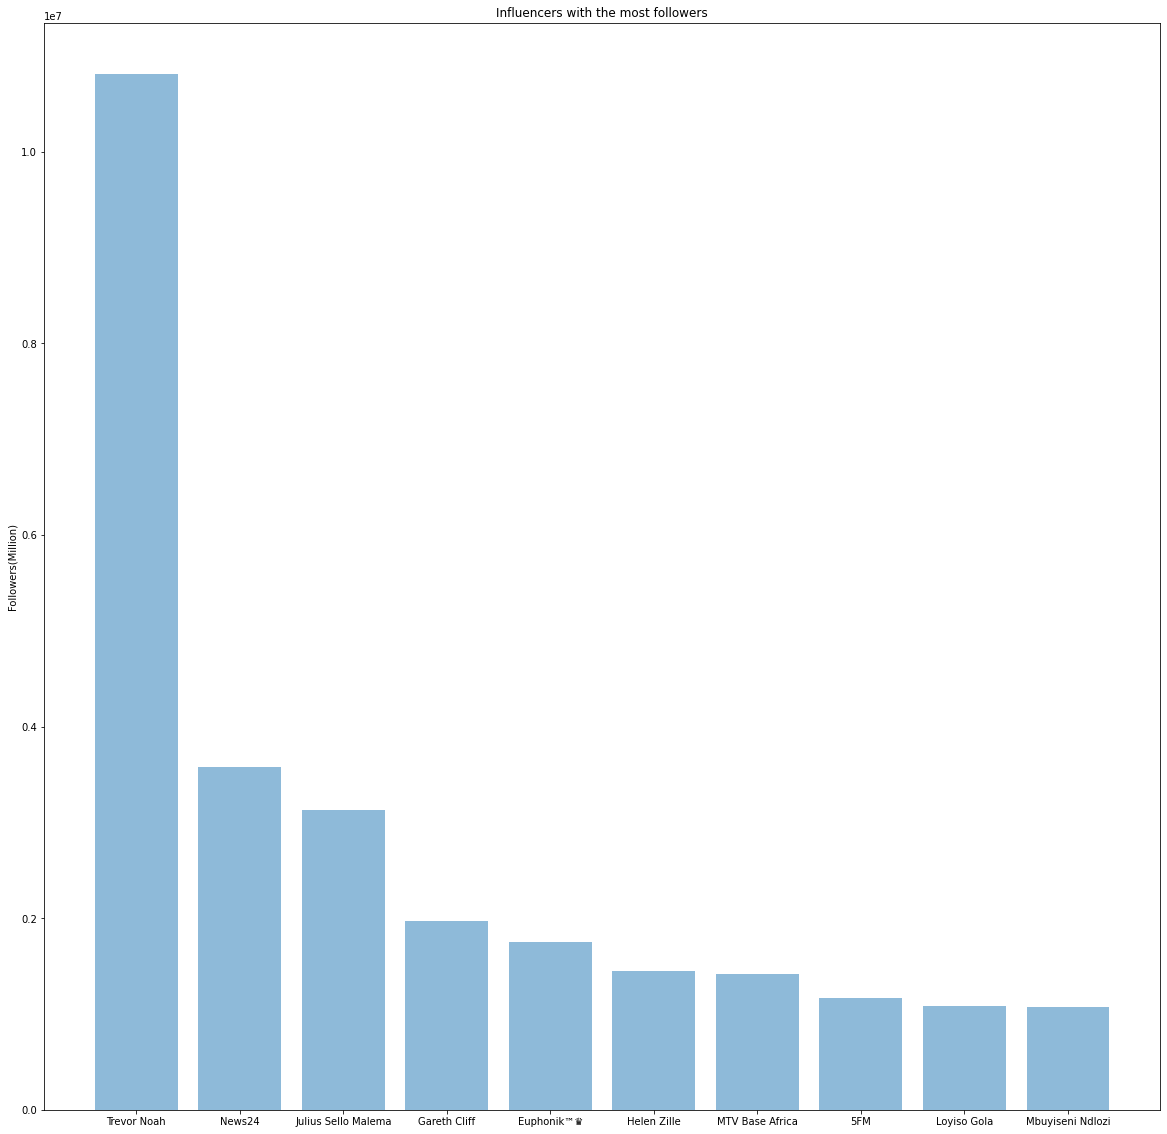

In [107]:
plt.figure(figsize=(20,20))
plt.bar(influ_bof[:10]['full name'],influ_bof[:10]['No of followers'], align='center', alpha=0.5)
plt.xticks(influ_bof[:10]['full name'])
plt.ylabel('Followers(Million)')
plt.title('Influencers with the most followers')

**REACH SCORE -- Top leaders Ranked based on numbers of followers**

In [124]:
lead_bof=rank(lea, 'No of followers')
lead_bof

,full name,No of followers,statusesCount,verified,twitter handle,favorite_count,retweet_count,user_mentions
ranking,,,,,,,,
1.0,Muhammadu Buhari,3271096,4734,True,mbuhari,90707,22974,100
2.0,Paul Kagame,1983302,2862,True,paulkagame,306703,67865,92
3.0,Yoweri K Museveni,1812467,6644,True,kagutamuseveni,161970,24100,99
4.0,Presidency | South Africa 🇿🇦,1598645,18881,True,presidencyza,10759,4462,84
5.0,Nana Akufo-Addo,1507263,7096,True,nakufoaddo,568444,103636,78
6.0,Macky Sall,1374917,2796,True,macky_sall,87801,11982,97
7.0,State House Kenya,1103549,9046,True,statehousekenya,51647,12377,86
8.0,Alassane Ouattara,832022,7138,True,aouattara_prci,41877,6431,100
9.0,President of Zimbabwe,546181,628,True,edmnangagwa,98447,18311,74


Text(0.5, 1.0, 'African leaders with the most followers')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127487 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127487 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127462 missing from current font.
  font.set_text(s, 0, flags=flags)


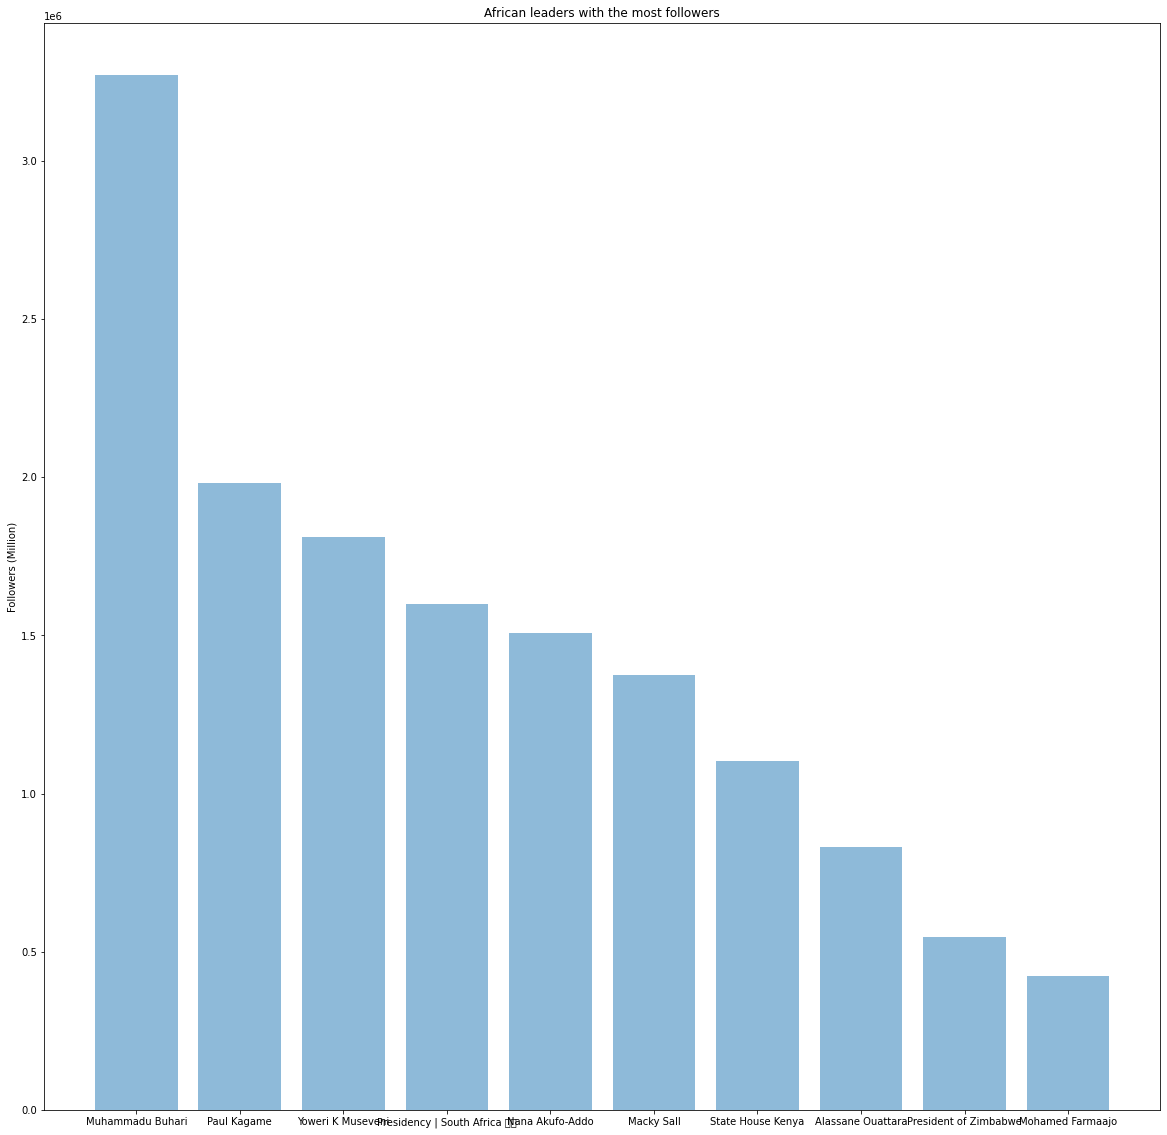

In [127]:
plt.figure(figsize=(20,20))
plt.bar(lead_bof[:10]['full name'],lead_bof[:10]['No of followers'], align='center', alpha=0.5)
plt.xticks(lead_bof[:10]['full name'])
plt.ylabel('Followers (Million)')
plt.title('African leaders with the most followers')

**POPULARITY SCORE --Influencers Ranked based on retweets**

In [128]:
influ_bor=rank(inf, 'retweet_count')
influ_bor

,full name,No of followers,statusesCount,verified,twitter handle,favorite_count,retweet_count,user_mentions
ranking,,,,,,,,
1.0,Trevor Noah,10805655,11185,True,trevornoah,741168,188905,36
2.0,Julius Sello Malema,3128409,37208,True,julius_s_malema,79838,15636,10
3.0,Mbuyiseni Ndlozi,1076669,35949,False,mbuyisenindlozi,67427,13590,29
4.0,Euphonik™♛,1755098,4521,True,euphonik,22325,2717,69
5.0,Ulrich Janse van Vuuren,1042496,19992,True,ulrichjvv,21098,2470,36
...,...,...,...,...,...,...,...,...
84.0,Africa Team,487,35,False,africamedia_cpj,0,1,35
84.0,SmithInAfrica,69,1,False,smithinafrica,0,1,1
87.0,Andrew H,7,6,False,bbcandrewh,1,0,6


Text(0.5, 1.0, 'Influencers with the highest Number of retweets')

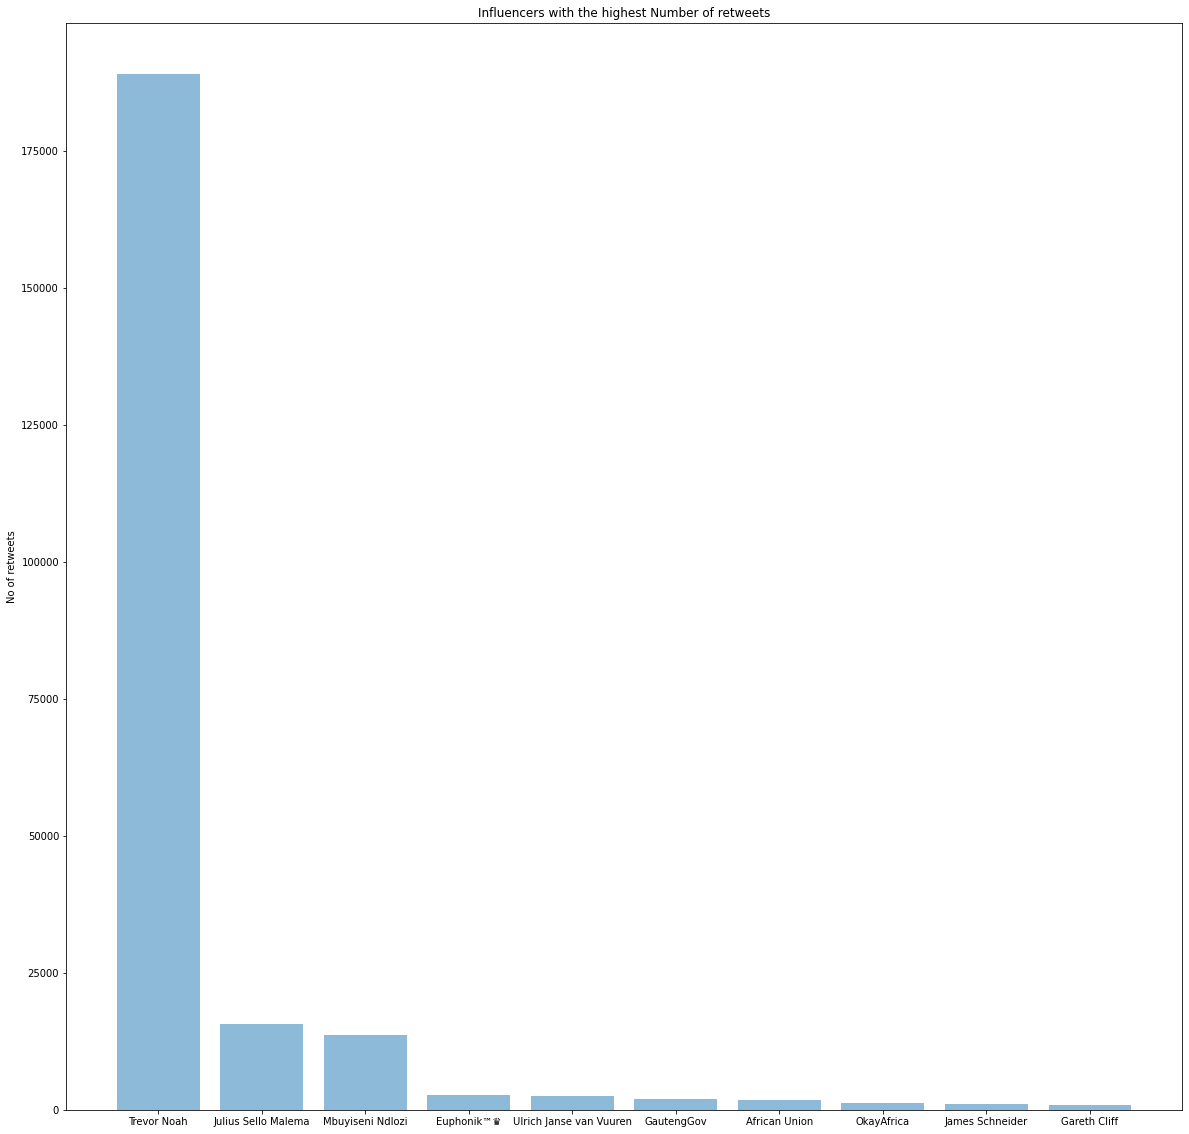

In [129]:
plt.figure(figsize=(20,20))
plt.bar(influ_bor[:10]['full name'],influ_bor[:10]['retweet_count'], align='center', alpha=0.5)
plt.xticks(influ_bor[:10]['full name'])
plt.ylabel('No of retweets')
plt.title('Influencers with the highest Number of retweets')

**POPULARITY SCORE --Top Leaders Ranked Based on retweets**

In [122]:
lead_bor = rank(lea, 'retweet_count')
lead_bor


,full name,No of followers,statusesCount,verified,twitter handle,favorite_count,retweet_count,user_mentions
ranking,,,,,,,,
1.0,Nana Akufo-Addo,1507263,7096,True,nakufoaddo,568444,103636,78
2.0,Paul Kagame,1983302,2862,True,paulkagame,306703,67865,92
3.0,Mohamed Farmaajo,424018,599,True,m_farmaajo,147823,27498,75
4.0,Abdalla Hamdok,370617,652,True,sudanpmhamdok,158149,27370,84
5.0,Yoweri K Museveni,1812467,6644,True,kagutamuseveni,161970,24100,99
6.0,Muhammadu Buhari,3271096,4734,True,mbuhari,90707,22974,100
7.0,President of Zimbabwe,546181,628,True,edmnangagwa,98447,18311,74
8.0,State House Kenya,1103549,9046,True,statehousekenya,51647,12377,86
9.0,Macky Sall,1374917,2796,True,macky_sall,87801,11982,97


Text(0.5, 1.0, 'African leaders with the highest Number of retweets')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127464 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127465 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127464 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127465 missing from current font.
  font.set_text(s, 0, flags=flags)


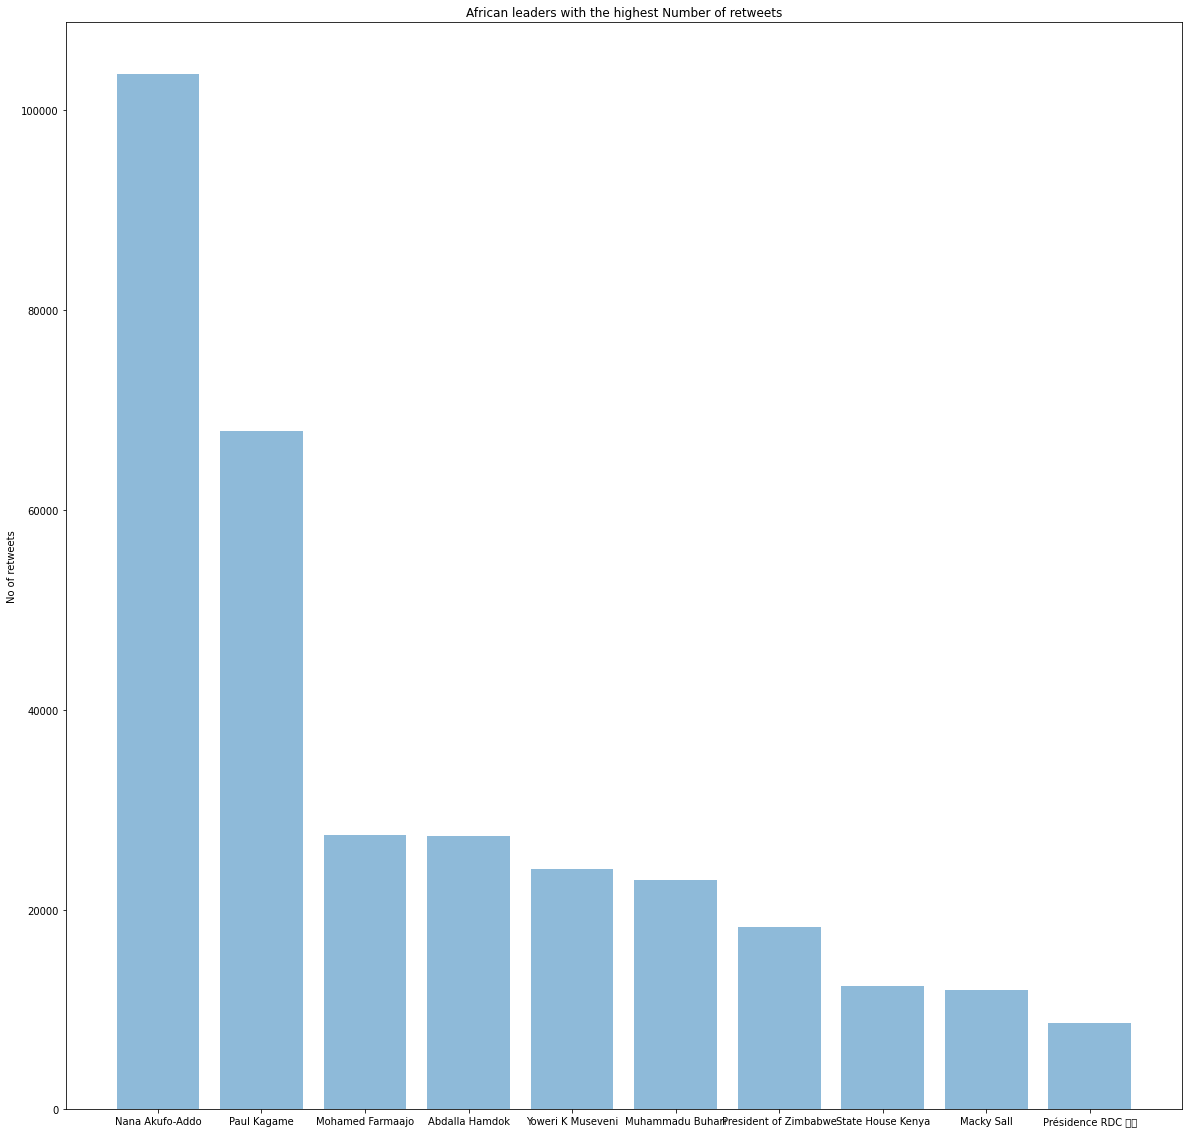

In [130]:
plt.figure(figsize=(20,20))
plt.bar(lead_bor[:10]['full name'],lead_bor[:10]['retweet_count'], align='center', alpha=0.5)
plt.xticks(lead_bor[:10]['full name'])
plt.ylabel('No of retweets')
plt.title('African leaders with the highest Number of retweets')

**RELEVANCE SCORE --Top Leaders Ranked Based on User Mentions**

In [121]:
lead_bom = rank(lea, 'user_mentions')
lead_bom

,full name,No of followers,statusesCount,verified,twitter handle,favorite_count,retweet_count,user_mentions
ranking,,,,,,,,
3.0,Alassane Ouattara,832022,7138,True,aouattara_prci,41877,6431,100
3.0,Chérif Mahamat Zene,18570,753,False,cherif_mz,21023,2535,100
3.0,Muhammadu Buhari,3271096,4734,True,mbuhari,90707,22974,100
6.0,Yoweri K Museveni,1812467,6644,True,kagutamuseveni,161970,24100,99
6.0,Presidence Mali,228831,11168,True,presidencemali,12344,2290,99
6.0,Presidente Cabo Verde,3282,714,False,presidenciacv,175,66,99
7.0,Issoufou Mahamadou,116186,349,True,issoufoumhm,48870,8274,98
9.0,Macky Sall,1374917,2796,True,macky_sall,87801,11982,97
9.0,MOFA/MRE -(Angola),3271,732,False,angola_mirex,2716,758,97


Text(0.5, 1.0, 'African leaders with the highest Number of User Mentions')

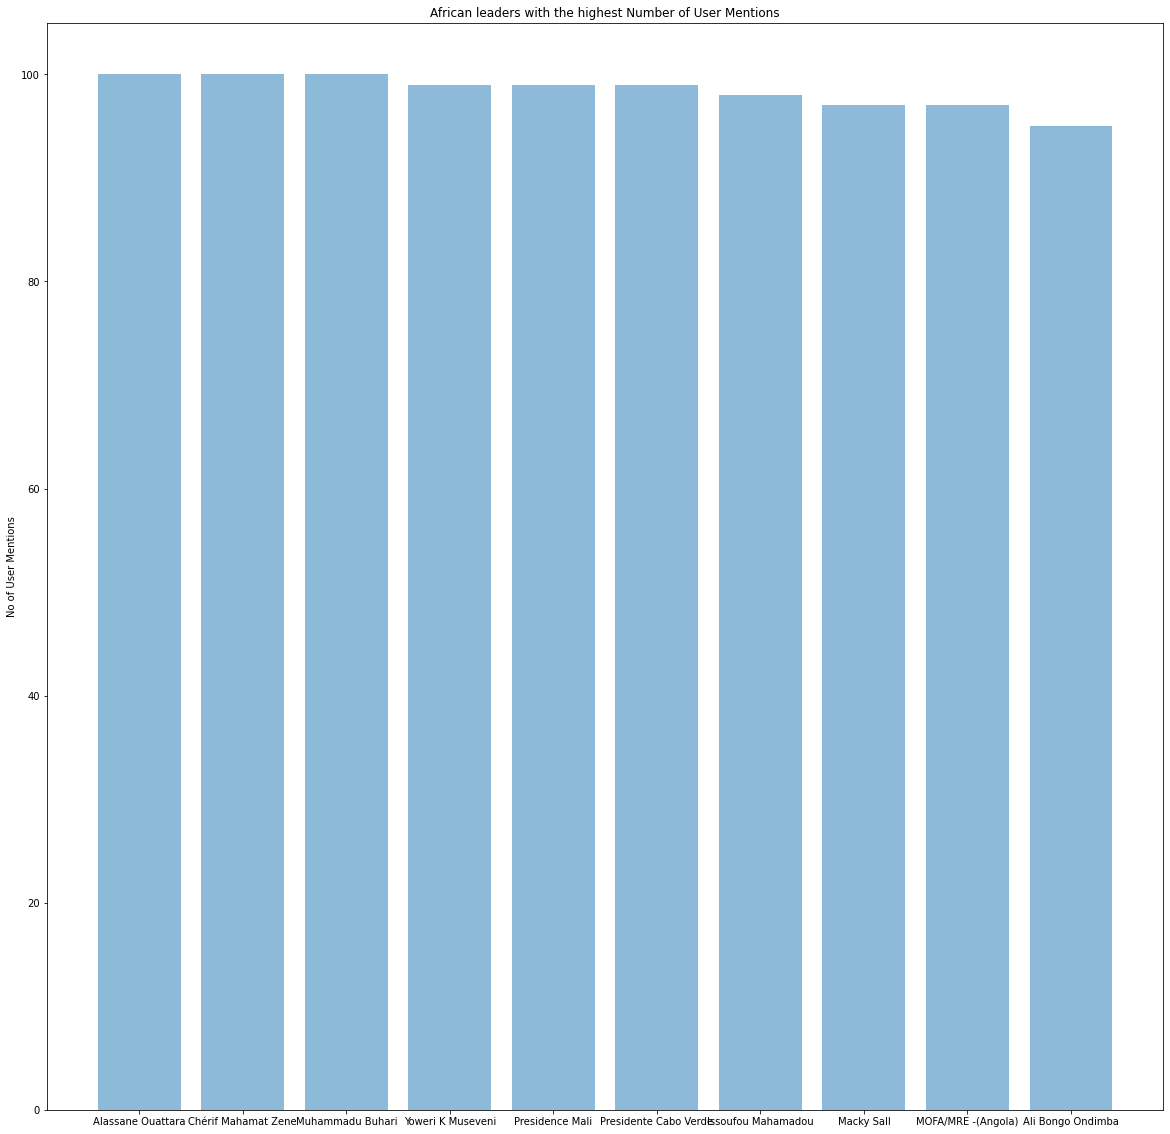

In [132]:
plt.figure(figsize=(20,20))
plt.bar(lead_bom[:10]['full name'],lead_bom[:10]['user_mentions'], align='center', alpha=0.5)
plt.xticks(lead_bom[:10]['full name'])
plt.ylabel('No of User Mentions')
plt.title('African leaders with the highest Number of User Mentions')

**RELEVANCE SCORE --Influencers Ranked Based on User Mentions**

In [138]:
influ_bom =rank(inf, 'user_mentions')
influ_bom


,full name,No of followers,statusesCount,verified,twitter handle,favorite_count,retweet_count,user_mentions
ranking,,,,,,,,
2.0,TechCentral,81631,18369,True,techcentral,121,100,100
2.0,VISI Magazine,52899,16888,False,visi_mag,458,163,100
4.0,Ranger Diaries,20452,3906,False,rangerdiaries,1606,732,99
4.0,marais,70757,4986,False,cx73,1045,83,99
5.0,Sandton City,56872,14684,True,sandtoncity,245,41,98
...,...,...,...,...,...,...,...,...
83.0,ArtSouthAfrica,116,23,False,artsouthafrica,8,4,3
85.0,Africa The Good News,50085,11100,False,africagoodnews,6,4,2
85.0,Jendayi E Frazer,29948,3118,False,jendayifrazer,10,3,2


Text(0.5, 1.0, 'Influencers with the highest Number of User Mentions')

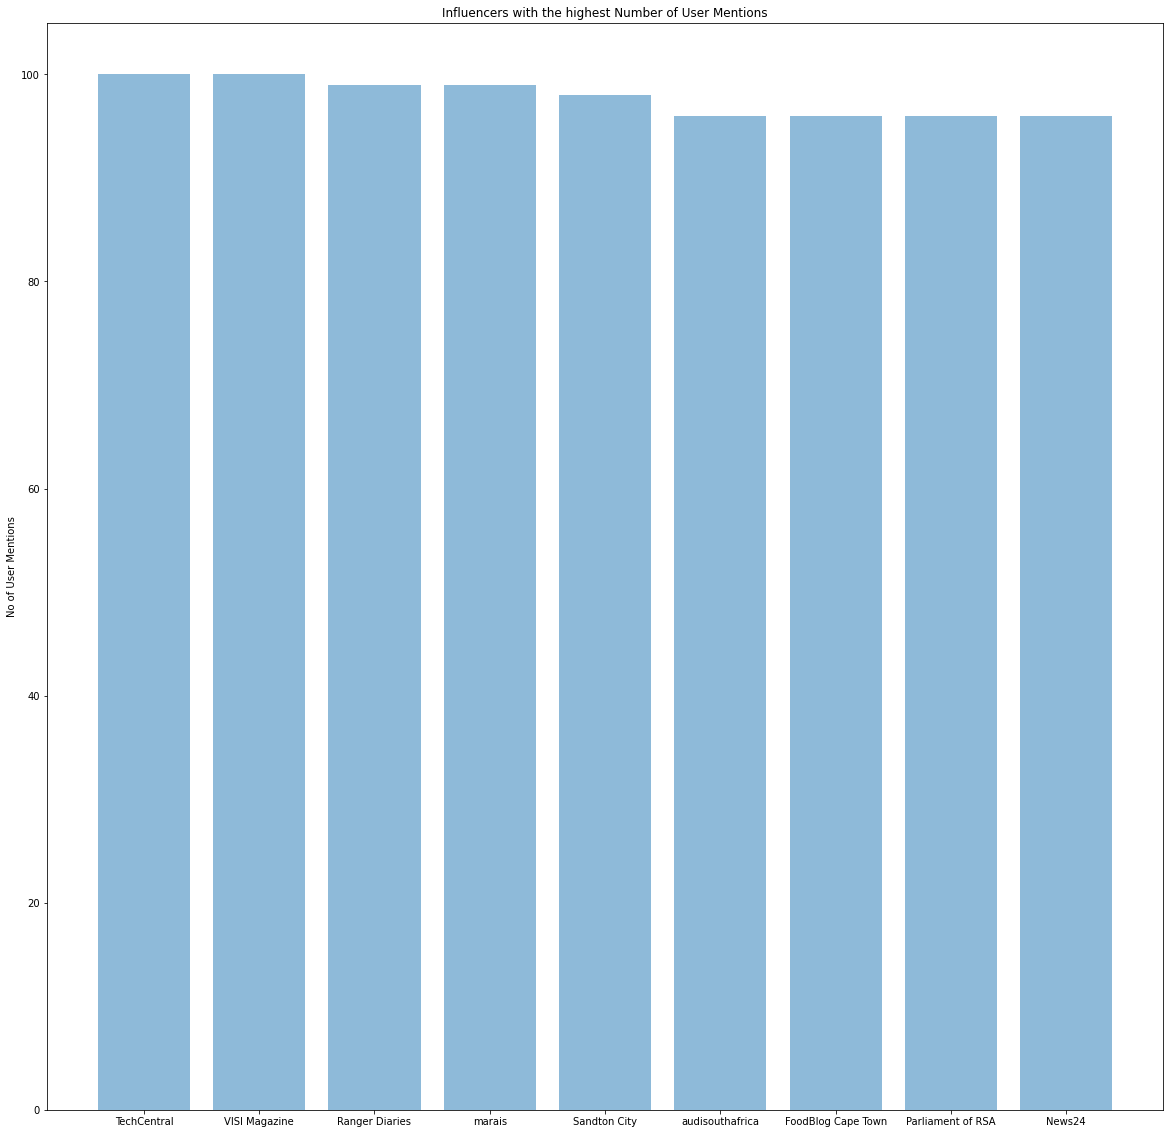

In [139]:
plt.figure(figsize=(20,20))
plt.bar(influ_bom[:10]['full name'],influ_bom[:10]['user_mentions'], align='center', alpha=0.5)
plt.xticks(influ_bom[:10]['full name'])
plt.ylabel('No of User Mentions')
plt.title('Influencers with the highest Number of User Mentions')

In [92]:
group_by_hash = df_lead.groupby('hashtags').source.count().nlargest(11)[1:]

def grp_by_hashtag(dataframe, series):
    df = pd.DataFrame()
    grpd = dataframe.groupby('hashtags')
    for key, _ in series.items():
        value_dict = {key : grpd.get_group(key)['original_author'].unique()}
        df_grp = pd.DataFrame(value_dict)
        df = pd.concat([df, df_grp], axis=1)
    return df

grpd_lea = grp_by_hashtag(df_lead, group_by_hash)
grpd_lea


,COVID19,Eritrea,"COVID19, FA4JR",ConseilDesMinistresSn,"FPE2020, MalawiDecides2020",RDC,Ramaphosa,Gabon,SierraLeone,InaugurationMalawi2020
0,paulkagame,hawelti,financesc,macky_sall,malawigovt,presidence_rdc,presidencyza,presidentabo,presidentbio,malawigovt
1,financesc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,m_farmaajo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,southsudangov,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,presidentabo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,presidency_gmb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,hagegeingob,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,nakufoaddo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,minsantedj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,presidence_rdc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
high_hash_inf = df_inf.groupby('hashtags').source.count().nlargest(11)[1:]
grpd_inf = grp_by_hashtag(df_inf, high_hash_inf)
grpd_inf

,COVID19,LiveAMP,MandelaDay,Ethiopia,AgainstAllOdds,Knysna,CNBCConversation,euNITE947,MTVBaseLounge,"COVID19, Masuku"
0,africagathering,liveamp,thestar_news,t_mcconnell,cnbcafrica,cx73,cnbcafrica,euphonik,mtvbaseafrica,gautengprovince
1,mercedesbenz_sa,NaN,parliamentofrsa,madeitinafrica,NaN,NaN,NaN,NaN,NaN,NaN
2,africaresearch,NaN,oneinafrica,jamalmosman,NaN,NaN,NaN,NaN,NaN,NaN
3,ifcafrica,NaN,visi_mag,mary_harper,NaN,NaN,NaN,NaN,NaN,NaN
4,oneinafrica,NaN,news24,aynte,NaN,NaN,NaN,NaN,NaN,NaN
5,mo_ibrahimfdn,NaN,ifcafrica,hamza_africa,NaN,NaN,NaN,NaN,NaN,NaN
6,_africanunion,NaN,cityofjoburgza,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,camfed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,savetherhino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,gautengprovince,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


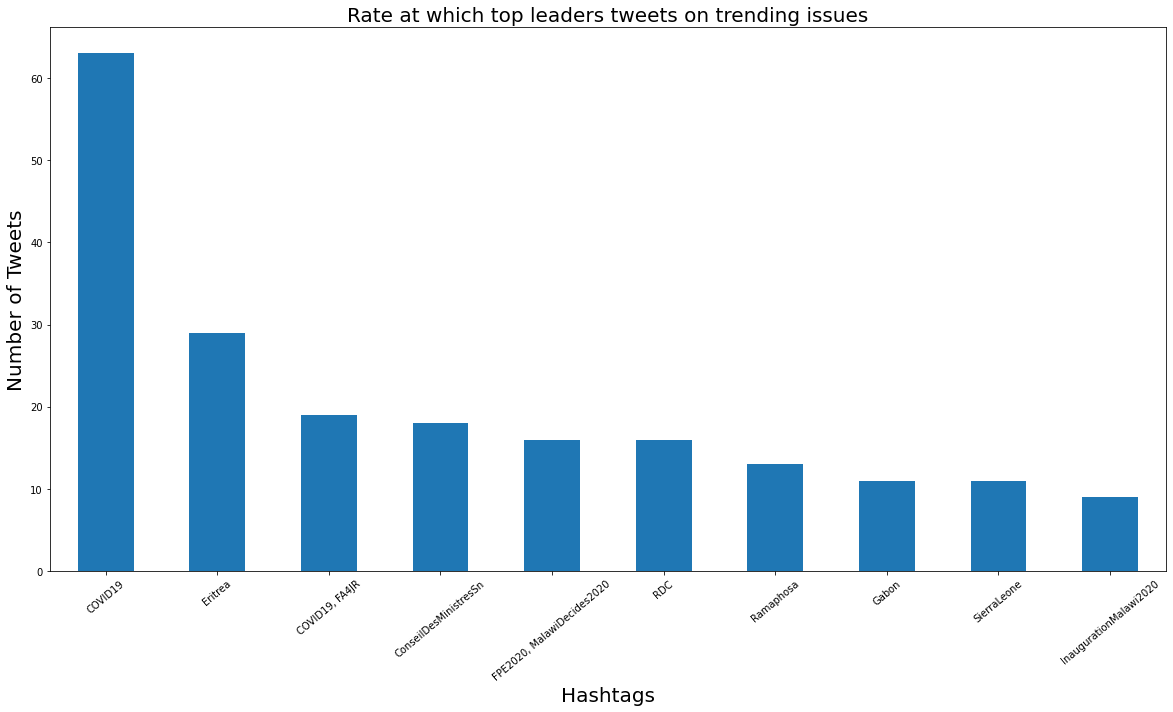

In [95]:
import matplotlib.pyplot as plt
def plot(need,title):
  fig, ax = plt.subplots(figsize=(20,10))
  ax.set_title(title, fontsize=20)
  need.groupby('hashtags').source.count().nlargest(11)[1:].plot.bar(rot=40)
  ax.set_xlabel('Hashtags', fontsize=20)
  ax.set_ylabel('Number of Tweets', fontsize=20)
title='Rate at which top leaders tweets on trending issues'
plot(df_lead,title)

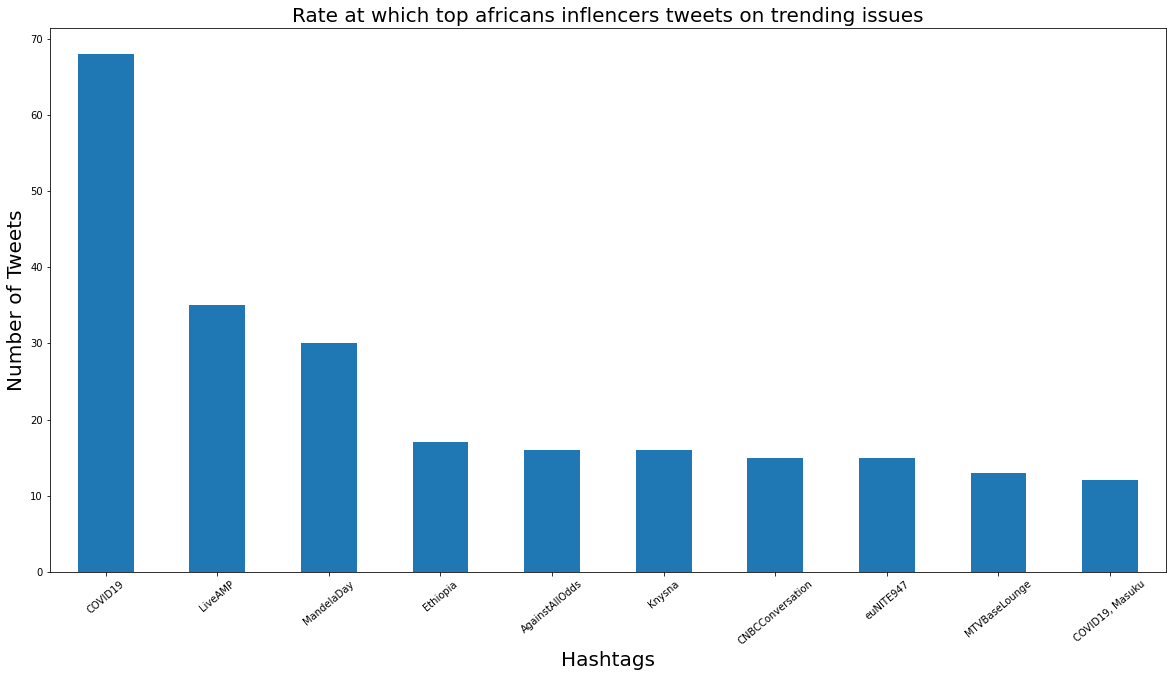

In [96]:
title_1='Rate at which top africans inflencers tweets on trending issues'
plot(df_inf,title_1)

## Web scrapping using bash script
If the web site has a quite simple HTML, you can easily use curl to perform the request and then extract the needed values using bash commands grep, cut , sed, ..

This tutorial is adapted from [this](https://medium.com/@LiliSousa/web-scraping-with-bash-690e4ee7f98d) medium article

In [ ]:
%%bash 

# curl the page and save content to tmp_file
#url = "https://www.atlanticcouncil.org/blogs/africasource/african-leaders-respond-to-coronavirus-on-twitter/#east-africa"
#curl -X GET $url -o tmp_file


#!/bin/bash

# write headers to CSV file
echo "Name, twitter_id" >> extractData.csv
n="1"
while [ $n -lt 2 ]
do
  
  #get title
  title=$(cat tmp_file | grep "class=\"twitter-tweet\"" | cut -d ';' -f1 )
  echo $title
  #get author
  #twitter_id=$(cat tmp_file |grep -A1 "class=\"css-901oao css-16my406 r-1qd0xha r-ad9z0x r-bcqeeo r-qvutc0\"" | tail -1)

  #echo "$title, $twitter_id" >> extractData.csv
  #echo "$title, $twitter_id"
    
  n=$[$n+1]

done

cat: tmp_file: No such file or directory
